In [2]:
import torch
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F
import torch.onnx

In [3]:
transform = transforms.Compose([
    transforms.ToTensor()])

trainset = torchvision.datasets.MNIST(root='./data', 
                                        train=True,
                                        download=True, 
                                        transform=transform)
train_loader =torch.utils.data.DataLoader(trainset,
                                         batch_size=4,
                                         shuffle=True,
                                         num_workers=4)

testset = torchvision.datasets.MNIST(root='./data',
                                     train=False,
                                     download=True,
                                     transform=transform)
test_loader = torch.utils.data.DataLoader(testset,
                                         batch_size=4,
                                         shuffle=False,
                                         num_workers=4)

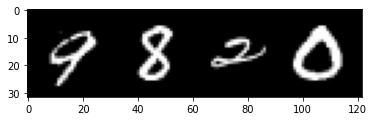

tensor([9, 8, 2, 0])


In [4]:
def imshow(img, title=None):
    img = img.numpy()
    plt.imshow(np.transpose(img, (1, 2, 0)))
    plt.show()
    
dataiter = iter(train_loader)
images, labels =dataiter.next()

grid = torchvision.utils.make_grid(images)

imshow(grid)
print(labels)

In [5]:
class FeedForward(nn.Module):
    def __init__(self):
        super(FeedForward, self).__init__()
        self.fc1 = nn.Linear( 28 * 28, 256)
        self.fc4 = nn.Linear(256, 128)
        self.fc5 = nn.Linear(128, 10)

    def forward(self, x):
        x = x.view(-1, 28 * 28)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc4(x))
        x = self.fc5(x)
        return x


In [8]:
class LeNet5(nn.Module):
    def __init__(self):
        super(LeNet5, self).__init__()
        # torch.nn.Conv2d(in_channels, out_channels,
        # kernel_size, stride=1, padding=0, dilation=1, 
        # groups=1, bias=True, padding_mode='zeros')
        
        # using same padding
        self.conv1 = nn.Conv2d(3, 18, kernel_size=5)
        self.conv2 = nn.Conv2d(18, 48, kernel_size=5)
        
        # torch.nn.MaxPool2d(kernel_size, stride=None, padding=0, dilation=1, 
        # return_indices=False, ceil_mode=False)
        self.pool = nn.MaxPool2d(2, 2)
        
        # flatten volume and pass through linear layers
        self.fc1 = nn.Linear(48*61*61, 360)
        self.fc2 = nn.Linear(360, 252)
        self.fc3 = nn.Linear(252, 50)
        
    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = self.pool(x)
        x = F.relu(self.conv2(x))
        x = self.pool(x)
        x = F.relu(self.fc1(x.view(-1, 48*61*61)))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        
        return x

In [9]:
class AlexNet(nn.Module):
    
    def __init__(self):
        super(AlexNet, self).__init__()
        # convolutional layers
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=96, kernel_size=11, stride=4)
        self.conv2 = nn.Conv2d(in_channels=96, out_channels=256, kernel_size=5, padding=2)
        self.conv3 = nn.Conv2d(in_channels=256, out_channels=384, kernel_size=3, padding=1)
        self.conv4 = nn.Conv2d(in_channels=384, out_channels=384, kernel_size=3, padding=1)
        self.conv5 = nn.Conv2d(in_channels=384, out_channels=256, kernel_size=3, padding=1)
        # dense/fully-connected layers
        self.fc1 = nn.Linear(256*6*6, 4096)
        self.fc2 = nn.Linear(4096, 4096)
        self.fc3 = nn.Linear(4096, 50)
        # pooling layer
        self.pool = nn.MaxPool2d(3, 2)
        
    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = self.pool(x)
        x = F.relu(self.conv2(x))
        x = self.pool(x)
        x = F.relu(self.conv3(x))
        x = F.relu(self.conv4(x))
        x = F.relu(self.conv5(x))
        x = self.pool(x)
        x = x.view(-1, 256*6*6)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x
            
    

In [10]:
def train_model(model, criterion, optimizer, trainloader, epochs=5, devloader=None, print_info=True, path=None):
    print('Starting Training...')
    # list for tracking metrics
    epoch_losses = []
    epoch_acces = []
    total = 0
    correct = 0
    # getting the usable device
    device = torch.device('cuda' if torch.cuda.is_available()  else 'cpu')
    print('Using device: ', device)
    minibatches = len(trainloader)
    # moving the model to the device we can use
    model = model.to(device)
    
    for epoch in range(epochs):
        epoch_loss = 0.0
        for batch, labels in trainloader:
            # moving the input and labels to the correct device
            batch, labels = batch.to(device), labels.to(device)
            
            # zero the optimizers gradient
            optimizer.zero_grad()
            
            # forward, backward, and optimization steps
            output = model(batch)
            loss = criterion(output, labels)
            loss.backward()
            optimizer.step()
            # adding the mini batch loss
            epoch_loss += loss.item()
            # calculating the accuacry
            total += labels.size(0)
            correct += (torch.max(output, 1)[1] == labels).sum().item()
            
        # tracking the epoch loss and accuracy
        epoch_losses.append(epoch_loss/minibatches)
        epoch_acces.append(correct/total)
        if print_info:
            print(f'Epoch: {epoch} Loss: {epoch_loss/minibatches} Accuracy: {correct/total}')
    if path:
        torch.save(model.state_dict(), path)
    return model, epoch_loss

In [14]:
model = FeedForward() 
model, _ = train_model(model, 
            epochs=2,
            criterion = nn.CrossEntropyLoss(),
            optimizer = optim.Adam(model.parameters(), lr=0.001, betas=(0.9, 0.999)),
            trainloader=train_loader,
            path='./big-FF.pth'
            )

Starting Training...
Using device:  cuda
Epoch: 0 Loss: 0.20303606103658675 Accuracy: 0.93835
Epoch: 1 Loss: 0.10146211560294031 Accuracy: 0.9544166666666667


In [19]:
def convert_to_onnx(model, path, output):
    model.to('cpu')
    model.load_state_dict(torch.load(path))
    model.eval()
    fake_input = torch.zeros(1, 28 *  28)
    torch.onnx.export(model, fake_input, output, verbose=True)

In [20]:
convert_to_onnx(model, 'big-FF.pth', 'big-FF.onnx')

graph(%0 : Float(1, 784),
      %fc1.weight : Float(256, 784),
      %fc1.bias : Float(256),
      %fc4.weight : Float(128, 256),
      %fc4.bias : Float(128),
      %fc5.weight : Float(10, 128),
      %fc5.bias : Float(10)):
  %7 : Tensor = onnx::Constant[value=  -1  784 [ CPULongType{2} ]]()
  %8 : Float(1, 784) = onnx::Reshape(%0, %7) # <ipython-input-6-dff2d70b9a4f>:9:0
  %9 : Float(1, 256) = onnx::Gemm[alpha=1., beta=1., transB=1](%8, %fc1.weight, %fc1.bias) # /home/aldo/miniconda3/envs/deep-learning/lib/python3.8/site-packages/torch/nn/functional.py:1610:0
  %10 : Float(1, 256) = onnx::Relu(%9) # /home/aldo/miniconda3/envs/deep-learning/lib/python3.8/site-packages/torch/nn/functional.py:1063:0
  %11 : Float(1, 128) = onnx::Gemm[alpha=1., beta=1., transB=1](%10, %fc4.weight, %fc4.bias) # /home/aldo/miniconda3/envs/deep-learning/lib/python3.8/site-packages/torch/nn/functional.py:1610:0
  %12 : Float(1, 128) = onnx::Relu(%11) # /home/aldo/miniconda3/envs/deep-learning/lib/python3.8/